In [3]:
# 필요한 라이브러리
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import cv2
from skimage import measure
import hdbscan
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import gc

# GPU 메모리 관리
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

# ============================================================================
# 🎯 Positional Encoding 핵심 함수들
# ============================================================================

def get_2d_positional_encoding(x, y, dim=64, max_len=10000):
    """
    2D sin/cos Positional Encoding
    
    Args:
        x, y: normalized coordinates (0~1 range)
        dim: encoding dimension (must be divisible by 4)
    """
    assert dim % 4 == 0, "dim must be divisible by 4 for 2D encoding"
    
    pos_encoding = np.zeros((len(x), dim))
    d_model_quarter = dim // 4
    div_term = np.exp(np.arange(0, d_model_quarter) * -(np.log(max_len) / d_model_quarter))
    
    # X coordinate encoding
    pos_encoding[:, 0::4] = np.sin(x[:, None] * div_term)
    pos_encoding[:, 1::4] = np.cos(x[:, None] * div_term)
    
    # Y coordinate encoding  
    pos_encoding[:, 2::4] = np.sin(y[:, None] * div_term)
    pos_encoding[:, 3::4] = np.cos(y[:, None] * div_term)
    
    return pos_encoding

def create_positional_features(df, pos_dim=64):
    """
    Create positional encoding from array coordinates (tissue별 상대좌표)
    """
    print("🔄 Creating positional encoding features...")
    
    pos_features_list = []
    
    # Tissue별로 정규화
    for tissue_id in df['tissue_index'].unique():
        tissue_mask = df['tissue_index'] == tissue_id
        tissue_data = df[tissue_mask]
        
        # Array 좌표 정규화 (0~1)
        x_coords = tissue_data['array_row'].values
        y_coords = tissue_data['array_col'].values
        
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        
        if x_max > x_min and y_max > y_min:
            x_norm = (x_coords - x_min) / (x_max - x_min)
            y_norm = (y_coords - y_min) / (y_max - y_min)
        else:
            x_norm = np.zeros_like(x_coords)
            y_norm = np.zeros_like(y_coords)
        
        # Positional encoding 생성
        tissue_pos = get_2d_positional_encoding(x_norm, y_norm, dim=pos_dim)
        pos_features_list.append(tissue_pos)
    
    pos_features = np.concatenate(pos_features_list)
    
    print(f"✅ Positional encoding created: {pos_features.shape}")
    return pos_features

# ==========================

In [6]:
#============================================================================
# Dataset & Feature Extractors
# ============================================================================

class TissueDataset(Dataset):
    def __init__(self, image_dir, df, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.df = df
        
        # ID에서 이미지 파일명 생성
        self.image_files = [f"{row['id']}.png" for _, row in df.iterrows()]
        print(f"Dataset loaded: {len(self.image_files)} images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(os.path.join(self.image_dir, img_name))
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_name

class MorphologicalFeatureExtractor:
    def __init__(self, white_weight=5.0, blue_weight=5.0):
        self.white_weight = white_weight
        self.blue_weight = blue_weight

    def extract_features(self, img):
        """형태학적 특징 추출"""
        img_uint8 = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)

        # 1. 흰색 영역 분석
        _, white_thresh = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)
        white_ratio = np.sum(white_thresh > 0) / white_thresh.size

        # 2. 원형도 계산
        contours, _ = cv2.findContours(white_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mean_circularity = 0.0
        if contours:
            circularities = []
            for cnt in contours:
                area = cv2.contourArea(cnt)
                perimeter = cv2.arcLength(cnt, True)
                if perimeter > 0 and area > 5:
                    circ = 4.0 * np.pi * area / (perimeter * perimeter)
                    circularities.append(circ)
            if circularities:
                mean_circularity = np.mean(circularities)

        # 3. 기본 특징들
        mean_gray = np.mean(gray) / 255.0
        edges = cv2.Canny(gray, 100, 200)
        boundary_ratio = np.sum(edges > 0) / edges.size

        # 4. 핵 분석
        nucleus_lower = np.array([100, 30, 30])
        nucleus_upper = np.array([160, 255, 255])
        nuclei_mask = cv2.inRange(hsv, nucleus_lower, nucleus_upper)
        nuclei_density = np.sum(nuclei_mask > 0) / nuclei_mask.size

        # 5. 블루 영역
        blue_lower = np.array([100, 50, 50])
        blue_upper = np.array([140, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        blue_ratio = np.sum(blue_mask > 0) / blue_mask.size

        # 가중치 적용된 특징 벡터
        features = np.array([
            self.white_weight * white_ratio,
            mean_circularity,
            mean_gray,
            boundary_ratio,
            nuclei_density,
            self.blue_weight * blue_ratio
        ], dtype=np.float32)

        return features

class FeatureExtractor:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"Using device: {device}")
        
        # ResNet18 로드
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Identity()  # 마지막 레이어 제거
        self.model = self.model.to(device)
        self.model.eval()
        
        # 형태학적 특징 추출기
        self.morph_extractor = MorphologicalFeatureExtractor()

    def extract_features(self, dataloader):
        """ResNet + 형태학적 특징 추출"""
        resnet_features = []
        morph_features = []
        names = []
        
        with torch.no_grad():
            for images, img_names in tqdm(dataloader, desc="Extracting features"):
                images = images.to(self.device)
                
                # ResNet 특징
                batch_resnet = self.model(images)
                
                # 형태학적 특징
                batch_images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
                batch_morph = np.array([
                    self.morph_extractor.extract_features(img) 
                    for img in batch_images_np
                ])
                
                resnet_features.append(batch_resnet.cpu().numpy())
                morph_features.append(batch_morph)
                names.extend(img_names)
                
                if len(resnet_features) % 10 == 0:
                    clear_gpu_memory()
        
        resnet_features = np.concatenate(resnet_features)
        morph_features = np.concatenate(morph_features)
        
        print(f"✅ Feature extraction complete:")
        print(f"   - ResNet features: {resnet_features.shape}")
        print(f"   - Morphological features: {morph_features.shape}")
        
        return resnet_features, morph_features, names


In [8]:
#============================================================================
# 🔥 Feature Fusion & Clustering
# ============================================================================

def fuse_features(resnet_features, pos_features, morph_features, 
                 resnet_weight=1.0, pos_weight=100.0, morph_weight=300.0):
    """
    특징 융합: ResNet + Positional Encoding + Morphology
    """
    print(f"🔗 Fusing features with weights:")
    print(f"   - ResNet: {resnet_weight}")
    print(f"   - Positional: {pos_weight}")
    print(f"   - Morphological: {morph_weight}")
    
    # L2 정규화 후 가중치 적용
    resnet_norm = resnet_features / np.linalg.norm(resnet_features, axis=1, keepdims=True)
    pos_norm = pos_features / np.linalg.norm(pos_features, axis=1, keepdims=True)
    morph_norm = morph_features / np.linalg.norm(morph_features, axis=1, keepdims=True)
    
    # 가중치 적용 후 결합
    fused_features = np.concatenate([
        resnet_norm * resnet_weight,
        pos_norm * pos_weight,
        morph_norm * morph_weight
    ], axis=1)
    
    print(f"✅ Fused features shape: {fused_features.shape}")
    return fused_features

def perform_clustering(features, save_dir=None):
    """UMAP + HDBSCAN 클러스터링"""
    print("🔄 Performing clustering...")
    
    # 특징 정규화
    features_scaled = StandardScaler().fit_transform(features)
    
    # UMAP 차원 축소
    print("   - UMAP dimension reduction...")
    reducer = umap.UMAP(
        n_neighbors=10,
        min_dist=0.001,
        n_components=2,
        random_state=42,
        metric='euclidean'
    )
    umap_embedded = reducer.fit_transform(features_scaled)
    
    # HDBSCAN 클러스터링
    print("   - HDBSCAN clustering...")
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=70,
        min_samples=3,
        cluster_selection_epsilon=0.05,
        metric='euclidean'
    )
    clusters = clusterer.fit_predict(umap_embedded)
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    
    print(f"✅ Clustering complete:")
    print(f"   - Clusters found: {n_clusters}")
    print(f"   - Noise points: {n_noise}")
    
    # 시각화
    if save_dir:
        plt.figure(figsize=(12, 8))
        
        # 노이즈 포인트
        noise_mask = clusters == -1
        plt.scatter(umap_embedded[noise_mask, 0], umap_embedded[noise_mask, 1],
                   c='lightgray', label='Noise', alpha=0.5, s=30)
        
        # 클러스터 포인트
        cluster_mask = ~noise_mask
        if np.any(cluster_mask):
            scatter = plt.scatter(umap_embedded[cluster_mask, 0], umap_embedded[cluster_mask, 1],
                                c=clusters[cluster_mask], cmap='tab20', alpha=0.8, s=40)
            plt.colorbar(scatter)
        
        plt.title(f'Clustering Results\n{n_clusters} clusters, {n_noise} noise points')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.savefig(os.path.join(save_dir, 'clustering_result.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    return umap_embedded, clusters



📂 Loading data...


Dataset loaded: 9269 images

🎯 Step 1: Creating positional encoding...
🔄 Creating positional encoding features...
✅ Positional encoding created: (9269, 64)

🎯 Step 2: Extracting ResNet + Morphological features...
Using device: cuda


Extracting features: 100%|██████████| 290/290 [00:49<00:00,  5.88it/s]
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Feature extraction complete:
   - ResNet features: (9269, 512)
   - Morphological features: (9269, 6)

🎯 Step 3: Fusing features...
🔗 Fusing features with weights:
   - ResNet: 1.0
   - Positional: 100.0
   - Morphological: 300.0
✅ Fused features shape: (9269, 582)

🎯 Step 4: Clustering...
🔄 Performing clustering...
   - UMAP dimension reduction...
   - HDBSCAN clustering...
✅ Clustering complete:
   - Clusters found: 9
   - Noise points: 576


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


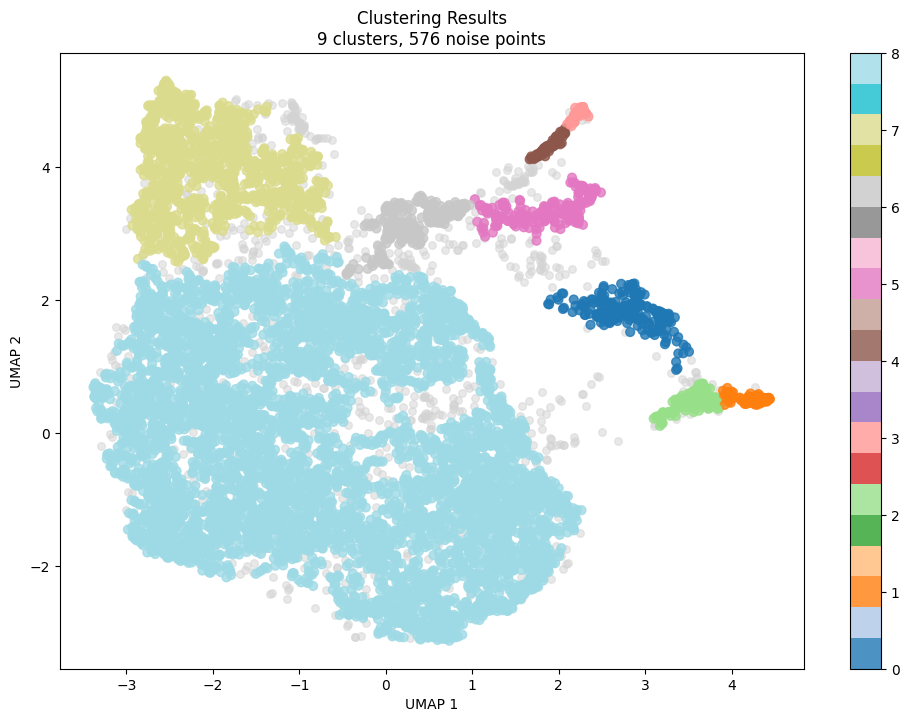


🎯 Step 5: Saving results...

📊 Cluster Statistics:
   Cluster -1: 576 samples
   Cluster 0: 252 samples
   Cluster 1: 114 samples
   Cluster 2: 107 samples
   Cluster 3: 79 samples
   Cluster 4: 96 samples
   Cluster 5: 216 samples
   Cluster 6: 210 samples
   Cluster 7: 1215 samples
   Cluster 8: 6404 samples

🎉 Complete! Results saved to 'clustering_results.csv'


In [10]:

# ============================================================================
# 🚀 MAIN 실행 함수
# ============================================================================

def main():
    # 데이터 로드
    print("📂 Loading data...")
    df = pd.read_csv('dataset.csv')
    
    # Transform 설정
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Dataset & DataLoader
    dataset = TissueDataset('train', df, transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # 🎯 1. Positional Encoding 생성
    print("\n🎯 Step 1: Creating positional encoding...")
    pos_features = create_positional_features(df, pos_dim=64)
    
    # 🎯 2. ResNet + 형태학적 특징 추출
    print("\n🎯 Step 2: Extracting ResNet + Morphological features...")
    extractor = FeatureExtractor()
    resnet_features, morph_features, names = extractor.extract_features(dataloader)
    
    # 🎯 3. 특징 융합
    print("\n🎯 Step 3: Fusing features...")
    fused_features = fuse_features(
        resnet_features, pos_features, morph_features,
        resnet_weight=1.0, pos_weight=100.0, morph_weight=300.0
    )
    
    # 🎯 4. 클러스터링
    print("\n🎯 Step 4: Clustering...")
    umap_embedded, clusters = perform_clustering(fused_features, save_dir='.')
    
    # 🎯 5. 결과 저장
    print("\n🎯 Step 5: Saving results...")
    results_df = pd.DataFrame({
        'image_name': names,
        'cluster': clusters,
        'array_row': df['array_row'].values,
        'array_col': df['array_col'].values,
        'tissue_index': df['tissue_index'].values
    })
    
    results_df.to_csv('clustering_results.csv', index=False)
    
    # 클러스터별 통계
    cluster_stats = results_df['cluster'].value_counts().sort_index()
    print(f"\n📊 Cluster Statistics:")
    for cluster_id, count in cluster_stats.items():
        print(f"   Cluster {cluster_id}: {count} samples")
    
    print("\n🎉 Complete! Results saved to 'clustering_results.csv'")

if __name__ == "__main__":
    main()

🔬 Histology-Specialized Clustering with Weight Optimization
📂 Loading data...


Dataset loaded: 9269 images

🎯 Step 1: Creating positional encoding...
🔄 Creating positional encoding features...
✅ Positional encoding created: (9269, 64)

🎯 Step 2: Extracting histology-specialized features...
Using device: cuda
🔬 Loading histology-specialized ResNet18 from weights/tenpercent_resnet18.ckpt
❌ Error loading histology weights: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pytorch_lightning.callbacks.m

Extracting histology features: 100%|██████████| 290/290 [00:48<00:00,  6.01it/s]


✅ Histology feature extraction complete:
   - ResNet features: (9269, 512)
   - Morphological features: (9269, 6)

🎯 Step 3: Comprehensive weight optimization...
🔍 Starting comprehensive weight optimization...
Testing 5 × 5 × 5 = 125 combinations


Testing weight combinations: 100%|██████████| 125/125 [28:51<00:00, 13.85s/it]



🏆 Top 20 combinations found!
 1. ResNet: 0.5 | Pos:  500 | Morph: 1000 | Sil:0.419 | Clusters:29
 2. ResNet: 1.0 | Pos:  500 | Morph: 1000 | Sil:0.419 | Clusters:29
 3. ResNet: 2.0 | Pos:  500 | Morph: 1000 | Sil:0.419 | Clusters:29
 4. ResNet: 0.1 | Pos:  500 | Morph: 1000 | Sil:0.387 | Clusters:30
 5. ResNet: 5.0 | Pos:   10 | Morph:  300 | Sil:0.363 | Clusters:27
 6. ResNet: 5.0 | Pos:  500 | Morph:   50 | Sil:0.312 | Clusters:27
 7. ResNet: 5.0 | Pos:  500 | Morph:  100 | Sil:0.312 | Clusters:27
 8. ResNet: 0.5 | Pos:   50 | Morph:  300 | Sil:0.257 | Clusters: 9
 9. ResNet: 0.5 | Pos:  100 | Morph:  300 | Sil:0.257 | Clusters: 9
10. ResNet: 1.0 | Pos:   50 | Morph:  300 | Sil:0.257 | Clusters: 9


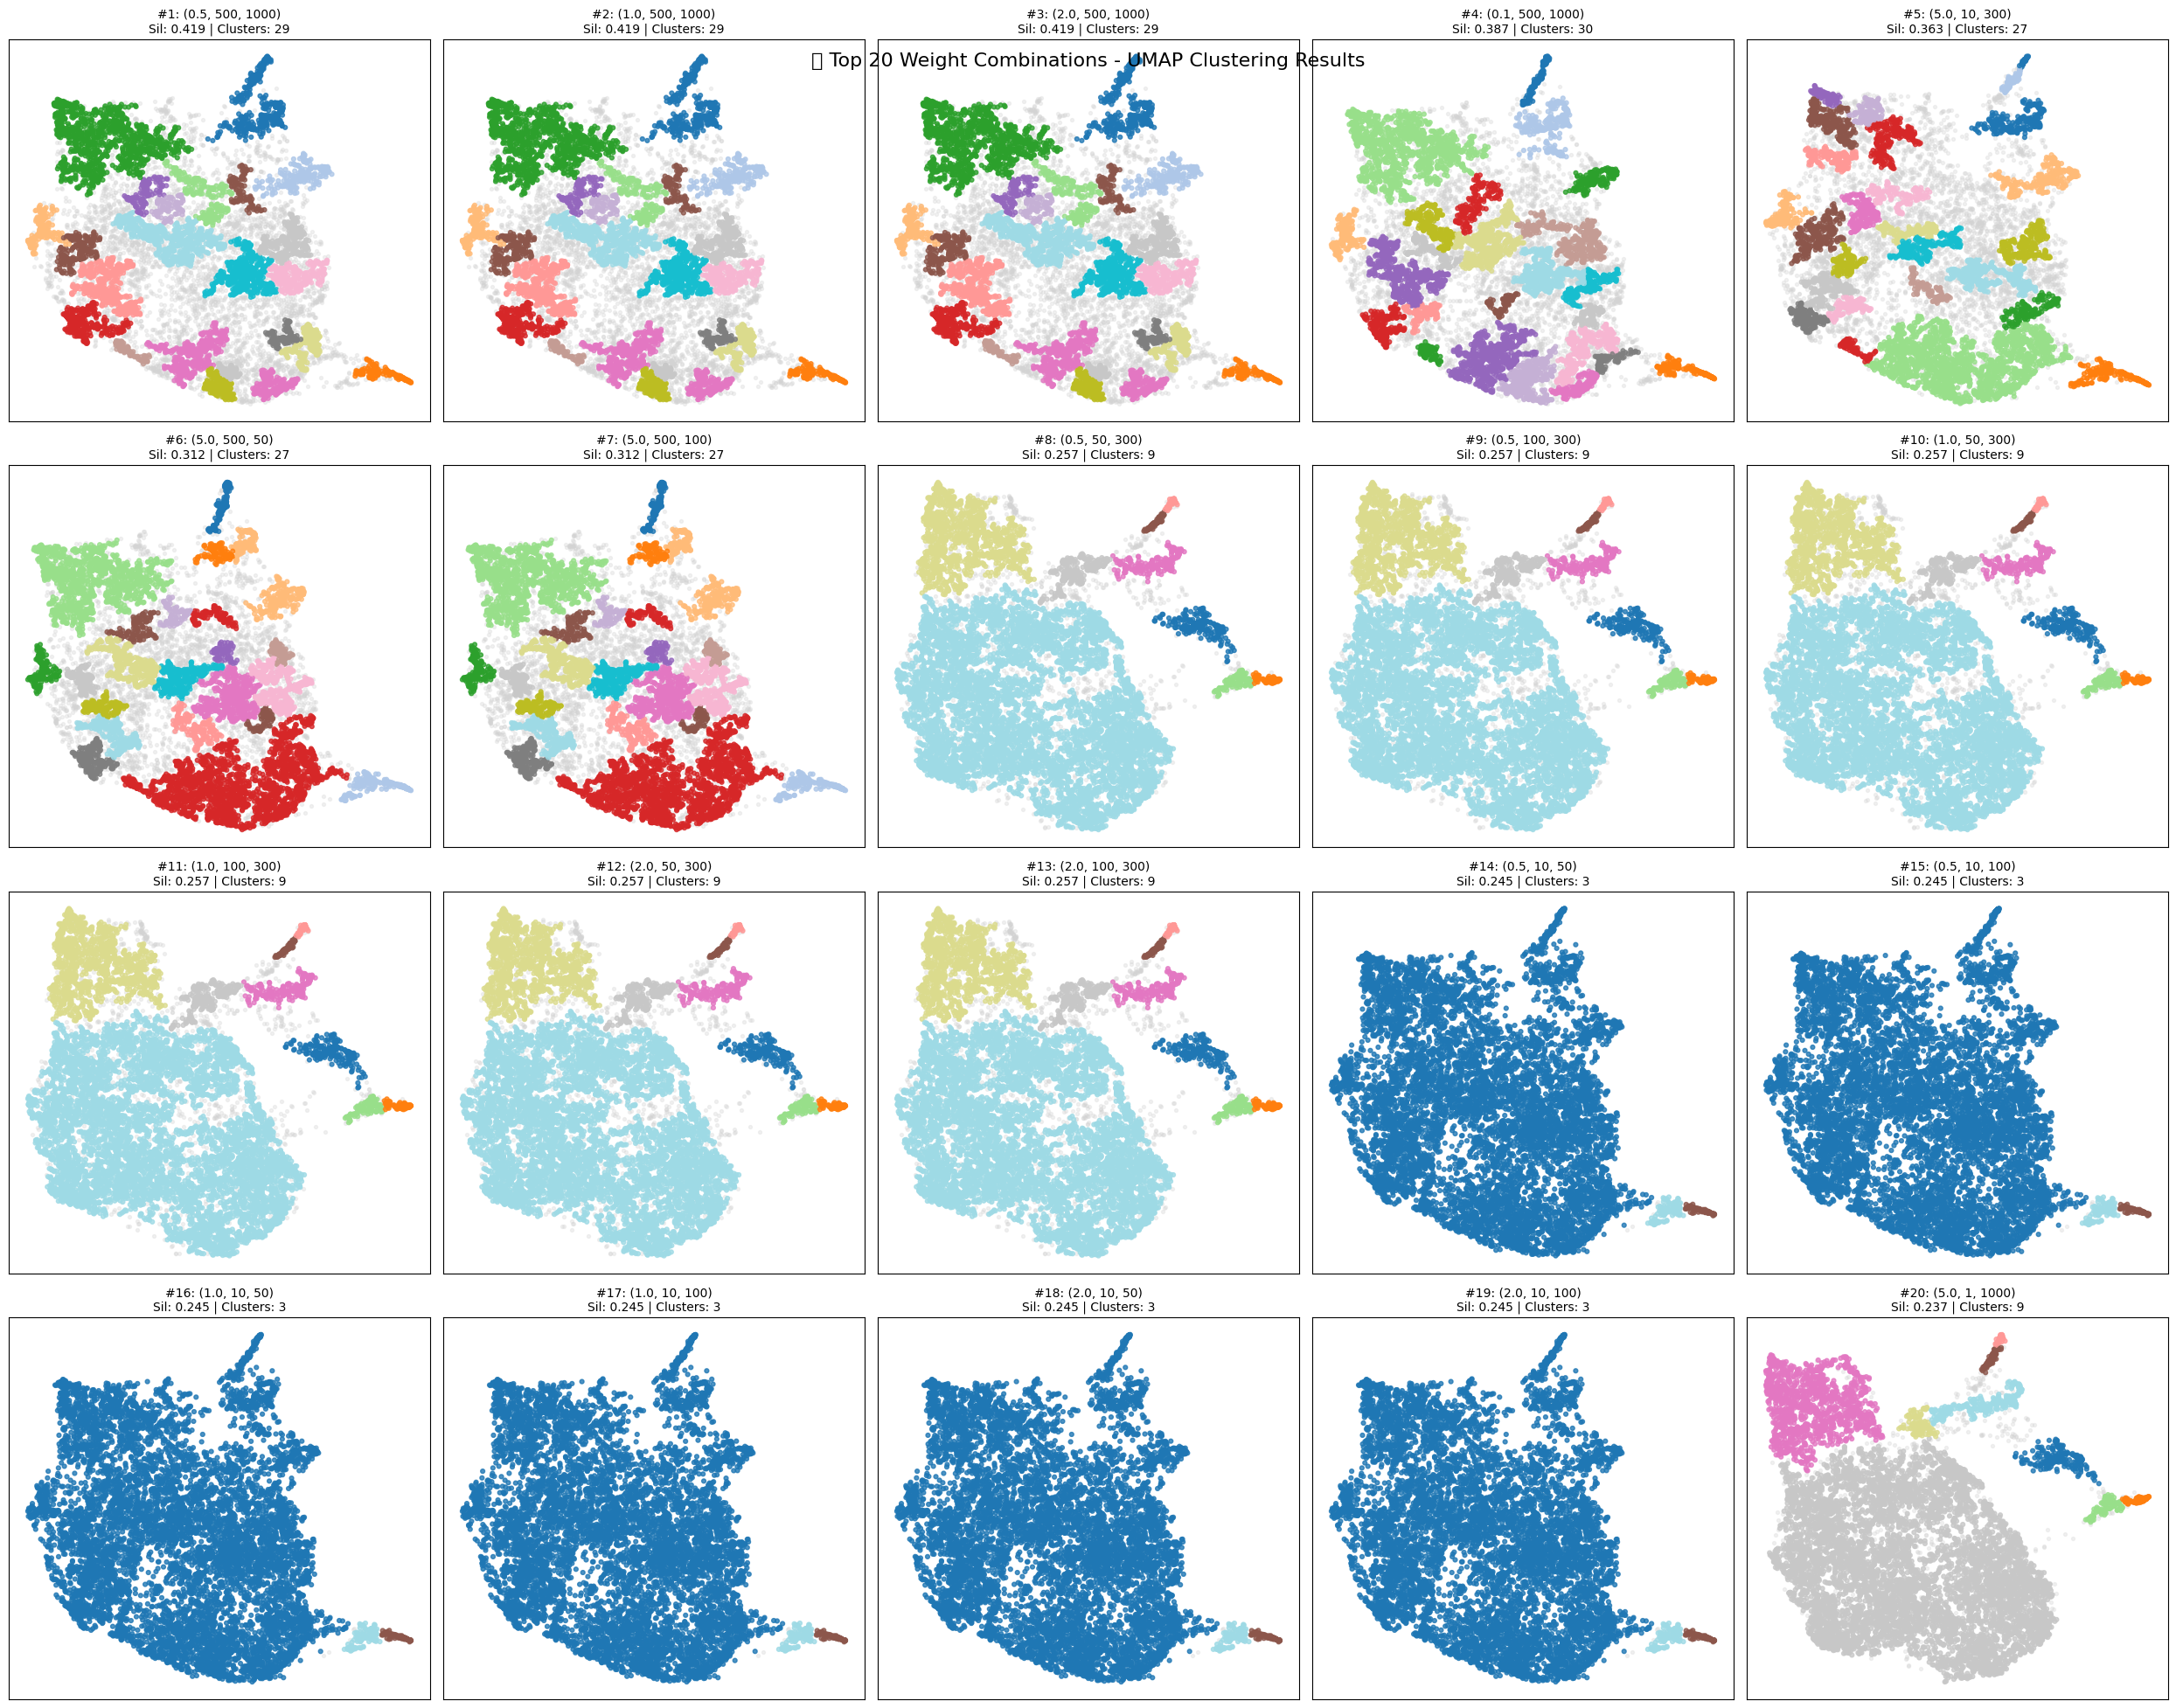

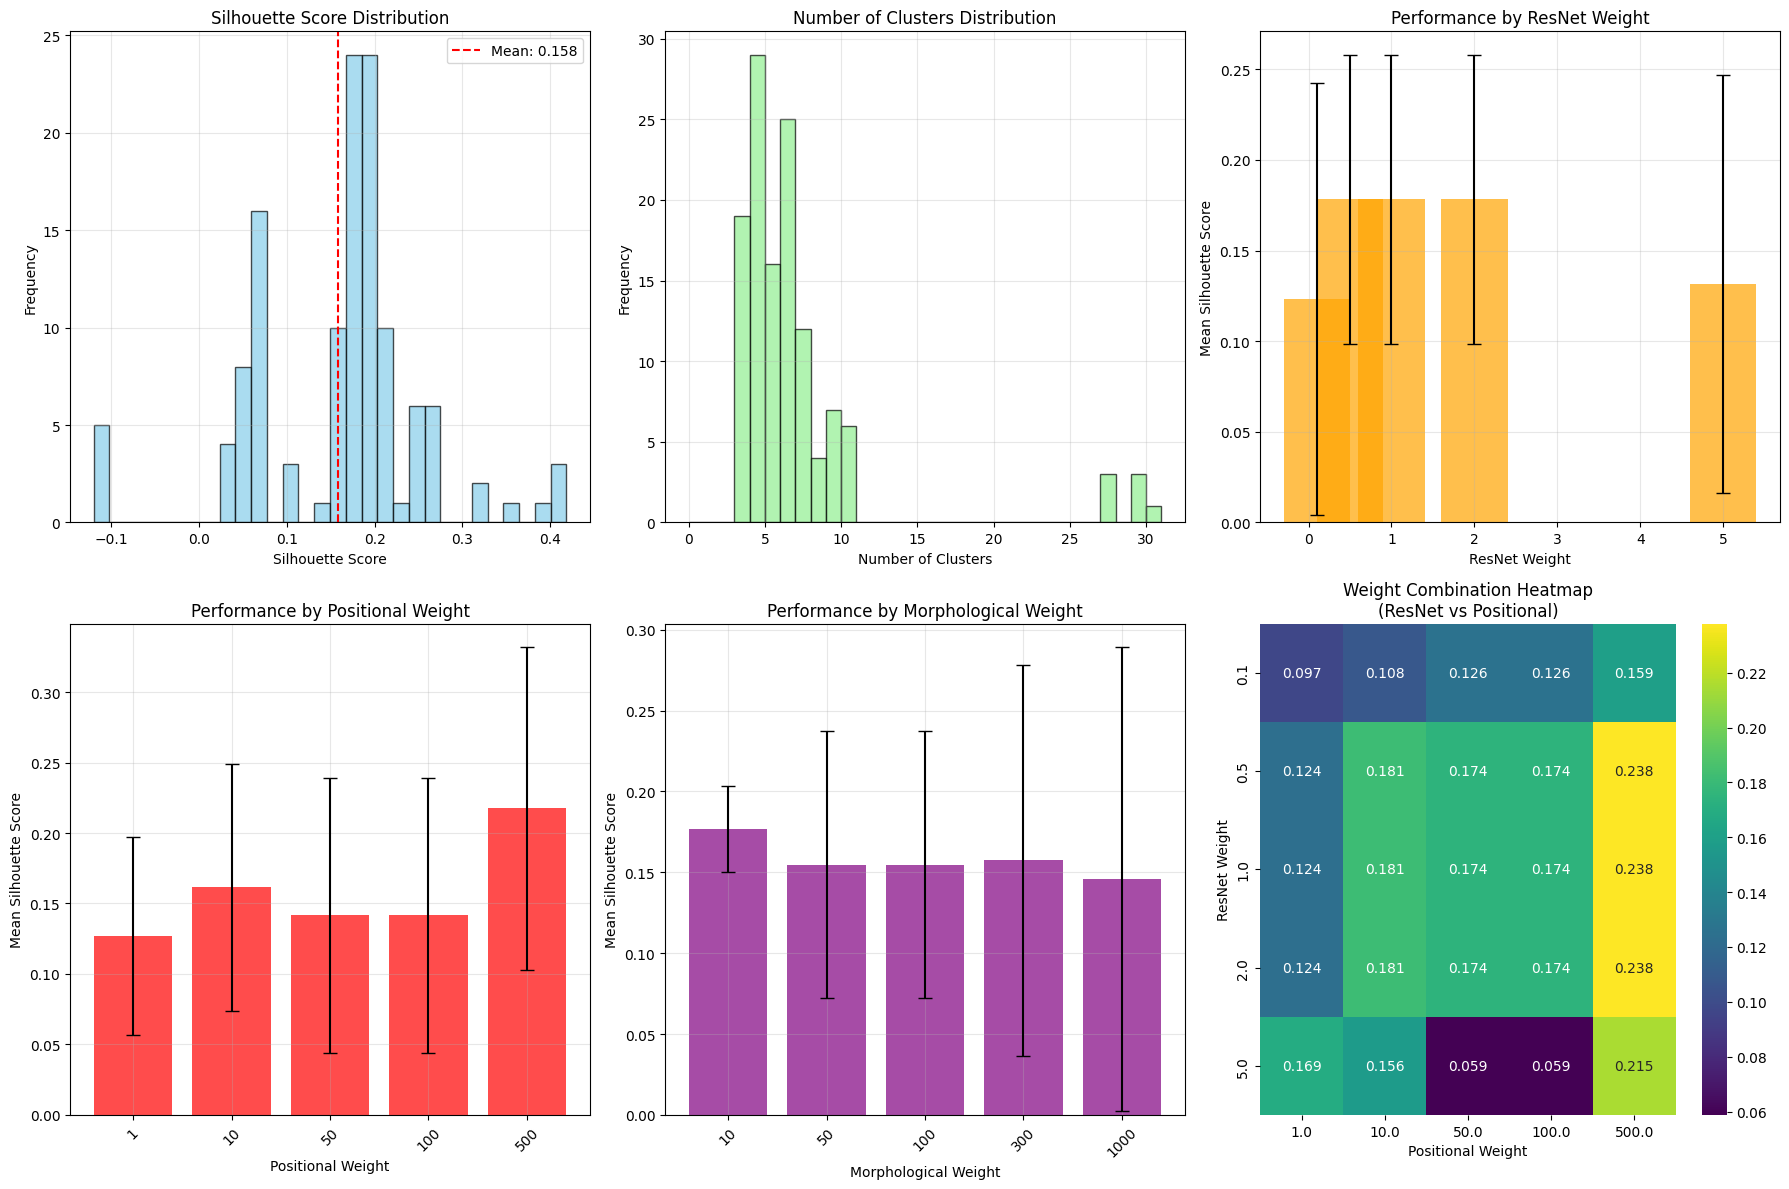


🎯 Step 4: Final clustering with best weights...

🎯 Step 5: Saving final results...

📊 Final Clustering Statistics (Best Combination):
   Best weights: ResNet=0.5, Pos=500, Morph=1000
   Silhouette Score: 0.419
   Number of clusters: 29
   Cluster distribution:
     Noise: 2841 samples
     Cluster 0: 215 samples
     Cluster 1: 241 samples
     Cluster 2: 250 samples
     Cluster 3: 71 samples
     Cluster 4: 112 samples
     Cluster 5: 177 samples
     Cluster 6: 1116 samples
     Cluster 7: 75 samples
     Cluster 8: 117 samples
     Cluster 9: 280 samples
     Cluster 10: 196 samples
     Cluster 11: 264 samples
     Cluster 12: 106 samples
     Cluster 13: 87 samples
     Cluster 14: 102 samples
     Cluster 15: 194 samples
     Cluster 16: 89 samples
     Cluster 17: 406 samples
     Cluster 18: 203 samples
     Cluster 19: 252 samples
     Cluster 20: 112 samples
     Cluster 21: 262 samples
     Cluster 22: 71 samples
     Cluster 23: 190 samples
     Cluster 24: 76 samples
   

In [15]:
# 필요한 라이브러리
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import cv2
import hdbscan
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# GPU 메모리 관리
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

# ============================================================================
# 🎯 Positional Encoding 핵심 함수들
# ============================================================================

def get_2d_positional_encoding(x, y, dim=64, max_len=10000):
    """
    2D sin/cos Positional Encoding
    
    Args:
        x, y: normalized coordinates (0~1 range)
        dim: encoding dimension (must be divisible by 4)
    """
    assert dim % 4 == 0, "dim must be divisible by 4 for 2D encoding"
    
    pos_encoding = np.zeros((len(x), dim))
    d_model_quarter = dim // 4
    div_term = np.exp(np.arange(0, d_model_quarter) * -(np.log(max_len) / d_model_quarter))
    
    # X coordinate encoding
    pos_encoding[:, 0::4] = np.sin(x[:, None] * div_term)
    pos_encoding[:, 1::4] = np.cos(x[:, None] * div_term)
    
    # Y coordinate encoding  
    pos_encoding[:, 2::4] = np.sin(y[:, None] * div_term)
    pos_encoding[:, 3::4] = np.cos(y[:, None] * div_term)
    
    return pos_encoding

def create_positional_features(df, pos_dim=64):
    """
    Create positional encoding from array coordinates (tissue별 상대좌표)
    """
    print("🔄 Creating positional encoding features...")
    
    pos_features_list = []
    
    # Tissue별로 정규화
    for tissue_id in df['tissue_index'].unique():
        tissue_mask = df['tissue_index'] == tissue_id
        tissue_data = df[tissue_mask]
        
        # Array 좌표 정규화 (0~1)
        x_coords = tissue_data['array_row'].values
        y_coords = tissue_data['array_col'].values
        
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        
        if x_max > x_min and y_max > y_min:
            x_norm = (x_coords - x_min) / (x_max - x_min)
            y_norm = (y_coords - y_min) / (y_max - y_min)
        else:
            x_norm = np.zeros_like(x_coords)
            y_norm = np.zeros_like(y_coords)
        
        # Positional encoding 생성
        tissue_pos = get_2d_positional_encoding(x_norm, y_norm, dim=pos_dim)
        pos_features_list.append(tissue_pos)
    
    pos_features = np.concatenate(pos_features_list)
    
    print(f"✅ Positional encoding created: {pos_features.shape}")
    return pos_features

# ============================================================================
# Dataset & Feature Extractors
# ============================================================================

class TissueDataset(Dataset):
    def __init__(self, image_dir, df, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.df = df
        
        # ID에서 이미지 파일명 생성
        self.image_files = [f"{row['id']}.png" for _, row in df.iterrows()]
        print(f"Dataset loaded: {len(self.image_files)} images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(os.path.join(self.image_dir, img_name))
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_name

class MorphologicalFeatureExtractor:
    def __init__(self, white_weight=5.0, blue_weight=5.0):
        self.white_weight = white_weight
        self.blue_weight = blue_weight

    def extract_features(self, img):
        """형태학적 특징 추출"""
        img_uint8 = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)

        # 1. 흰색 영역 분석
        _, white_thresh = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)
        white_ratio = np.sum(white_thresh > 0) / white_thresh.size

        # 2. 원형도 계산
        contours, _ = cv2.findContours(white_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mean_circularity = 0.0
        if contours:
            circularities = []
            for cnt in contours:
                area = cv2.contourArea(cnt)
                perimeter = cv2.arcLength(cnt, True)
                if perimeter > 0 and area > 5:
                    circ = 4.0 * np.pi * area / (perimeter * perimeter)
                    circularities.append(circ)
            if circularities:
                mean_circularity = np.mean(circularities)

        # 3. 기본 특징들
        mean_gray = np.mean(gray) / 255.0
        edges = cv2.Canny(gray, 100, 200)
        boundary_ratio = np.sum(edges > 0) / edges.size

        # 4. 핵 분석
        nucleus_lower = np.array([100, 30, 30])
        nucleus_upper = np.array([160, 255, 255])
        nuclei_mask = cv2.inRange(hsv, nucleus_lower, nucleus_upper)
        nuclei_density = np.sum(nuclei_mask > 0) / nuclei_mask.size

        # 5. 블루 영역
        blue_lower = np.array([100, 50, 50])
        blue_upper = np.array([140, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        blue_ratio = np.sum(blue_mask > 0) / blue_mask.size

        # 가중치 적용된 특징 벡터
        features = np.array([
            self.white_weight * white_ratio,
            mean_circularity,
            mean_gray,
            boundary_ratio,
            nuclei_density,
            self.blue_weight * blue_ratio
        ], dtype=np.float32)

        return features

# ============================================================================
# 🔬 조직병리학 특화 ResNet18 로더
# ============================================================================

def load_histology_resnet18(model_path='weights/tenpercent_resnet18.ckpt', device='cuda'):
    """
    조직병리학 특화 ResNet18 모델 로드
    """
    print(f"🔬 Loading histology-specialized ResNet18 from {model_path}")
    
    def load_model_weights(model, weights):
        model_dict = model.state_dict()
        weights = {k: v for k, v in weights.items() if k in model_dict}
        if weights == {}:
            print('❌ No weight could be loaded..')
        model_dict.update(weights)
        model.load_state_dict(model_dict)
        return model
    
    # ResNet18 모델 생성 (pretrained=False)
    model = models.resnet18(pretrained=False)
    
    try:
        # 체크포인트 로드
        state = torch.load(model_path, map_location=device)
        state_dict = state['state_dict']
        
        # 키 이름 정리 (model., resnet. 제거)
        for key in list(state_dict.keys()):
            state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)
        
        # 가중치 로드
        model = load_model_weights(model, state_dict)
        
        # FC layer를 Identity로 변경 (특징 추출용)
        model.fc = nn.Identity()
        
        model = model.to(device)
        model.eval()
        
        print("✅ Histology-specialized ResNet18 loaded successfully!")
        return model
        
    except Exception as e:
        print(f"❌ Error loading histology weights: {e}")
        print("🔄 Falling back to ImageNet pretrained ResNet18...")
        
        # ImageNet 사전훈련 모델로 폴백
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Identity()
        model = model.to(device)
        model.eval()
        
        return model

class HistologyFeatureExtractor:
    def __init__(self, model_path='weights/tenpercent_resnet18.ckpt', 
                 device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"Using device: {device}")
        
        # 조직병리학 특화 ResNet18 로드
        self.model = load_histology_resnet18(model_path, device)
        
        # 형태학적 특징 추출기
        self.morph_extractor = MorphologicalFeatureExtractor()

    def extract_features(self, dataloader):
        """조직병리학 ResNet18 + 형태학적 특징 추출"""
        resnet_features = []
        morph_features = []
        names = []
        
        with torch.no_grad():
            for images, img_names in tqdm(dataloader, desc="Extracting histology features"):
                images = images.to(self.device)
                
                # 조직병리학 특화 ResNet 특징
                batch_resnet = self.model(images)
                
                # 형태학적 특징
                batch_images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
                batch_morph = np.array([
                    self.morph_extractor.extract_features(img) 
                    for img in batch_images_np
                ])
                
                resnet_features.append(batch_resnet.cpu().numpy())
                morph_features.append(batch_morph)
                names.extend(img_names)
                
                if len(resnet_features) % 10 == 0:
                    clear_gpu_memory()
        
        resnet_features = np.concatenate(resnet_features)
        morph_features = np.concatenate(morph_features)
        
        print(f"✅ Histology feature extraction complete:")
        print(f"   - ResNet features: {resnet_features.shape}")
        print(f"   - Morphological features: {morph_features.shape}")
        
        return resnet_features, morph_features, names

# ============================================================================
# 🔥 Feature Fusion & Clustering
# ============================================================================

def fuse_features(resnet_features, pos_features, morph_features, 
                 resnet_weight=1.0, pos_weight=100.0, morph_weight=300.0):
    """
    특징 융합: Histology ResNet + Positional Encoding + Morphology
    """
    # L2 정규화 후 가중치 적용
    resnet_norm = resnet_features / np.linalg.norm(resnet_features, axis=1, keepdims=True)
    pos_norm = pos_features / np.linalg.norm(pos_features, axis=1, keepdims=True)
    morph_norm = morph_features / np.linalg.norm(morph_features, axis=1, keepdims=True)
    
    # 가중치 적용 후 결합
    fused_features = np.concatenate([
        resnet_norm * resnet_weight,
        pos_norm * pos_weight,
        morph_norm * morph_weight
    ], axis=1)
    
    return fused_features

def evaluate_clustering(features, clusters):
    """클러스터링 성능 평가"""
    if len(set(clusters)) <= 1:  # 클러스터가 1개 이하면 평가 불가
        return {'silhouette': -1, 'calinski': 0, 'davies': float('inf'), 'n_clusters': 0}
    
    # 노이즈 포인트 제거
    valid_mask = clusters != -1
    if np.sum(valid_mask) < 2:
        return {'silhouette': -1, 'calinski': 0, 'davies': float('inf'), 'n_clusters': 0}
    
    valid_features = features[valid_mask]
    valid_clusters = clusters[valid_mask]
    
    if len(set(valid_clusters)) <= 1:
        return {'silhouette': -1, 'calinski': 0, 'davies': float('inf'), 'n_clusters': len(set(valid_clusters))}
    
    try:
        silhouette = silhouette_score(valid_features, valid_clusters)
        calinski = calinski_harabasz_score(valid_features, valid_clusters)
        davies = davies_bouldin_score(valid_features, valid_clusters)
        n_clusters = len(set(valid_clusters))
        
        return {
            'silhouette': silhouette,
            'calinski': calinski,
            'davies': davies,
            'n_clusters': n_clusters
        }
    except:
        return {'silhouette': -1, 'calinski': 0, 'davies': float('inf'), 'n_clusters': 0}

def perform_clustering_with_eval(features):
    """UMAP + HDBSCAN 클러스터링 및 평가"""
    # 특징 정규화
    features_scaled = StandardScaler().fit_transform(features)
    
    # UMAP 차원 축소
    reducer = umap.UMAP(
        n_neighbors=10,
        min_dist=0.001,
        n_components=2,
        random_state=42,
        metric='euclidean'
    )
    umap_embedded = reducer.fit_transform(features_scaled)
    
    # HDBSCAN 클러스터링
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=70,
        min_samples=3,
        cluster_selection_epsilon=0.05,
        metric='euclidean'
    )
    clusters = clusterer.fit_predict(umap_embedded)
    
    # 성능 평가
    metrics = evaluate_clustering(umap_embedded, clusters)
    
    return umap_embedded, clusters, metrics

# ============================================================================
# 🚀 가중치 조합 최적화 및 시각화
# ============================================================================

def comprehensive_weight_optimization(resnet_features, pos_features, morph_features, save_dir='.'):
    """
    모든 가중치 조합에 대해 클러스터링 수행 및 UMAP 시각화
    """
    print("🔍 Starting comprehensive weight optimization...")
    
    # 다양한 가중치 조합 정의
    resnet_weights = [0.1, 0.5, 1.0, 2.0, 5.0]
    pos_weights = [1.0, 10.0, 50.0, 100.0, 500.0]  
    morph_weights = [10.0, 50.0, 100.0, 300.0, 1000.0]
    
    print(f"Testing {len(resnet_weights)} × {len(pos_weights)} × {len(morph_weights)} = {len(resnet_weights) * len(pos_weights) * len(morph_weights)} combinations")
    
    # 결과 저장
    all_results = []
    plot_data = []
    
    combination_idx = 0
    total_combinations = len(resnet_weights) * len(pos_weights) * len(morph_weights)
    
    combinations = list(product(resnet_weights, pos_weights, morph_weights))
    
    for i, (rw, pw, mw) in enumerate(tqdm(combinations, desc="Testing weight combinations")):
                try:
                    # 특징 융합
                    fused_features = fuse_features(resnet_features, pos_features, morph_features,
                                                 resnet_weight=rw, pos_weight=pw, morph_weight=mw)
                    
                    # 클러스터링 및 평가
                    umap_embedded, clusters, metrics = perform_clustering_with_eval(fused_features)
                    
                    result = {
                        'combination_idx': i,
                        'resnet_weight': rw,
                        'pos_weight': pw,  
                        'morph_weight': mw,
                        'silhouette': metrics['silhouette'],
                        'calinski': metrics['calinski'],
                        'davies': metrics['davies'],
                        'n_clusters': metrics['n_clusters'],
                        'umap_embedded': umap_embedded,
                        'clusters': clusters
                    }
                    
                    all_results.append(result)
                    
                    # 플롯용 데이터 저장 (상위 성능만)
                    if metrics['silhouette'] > 0.1:  # 유의미한 클러스터링만
                        plot_data.append(result)
                    
                except Exception as e:
                    print(f"Error with combination ({rw}, {pw}, {mw}): {e}")
                    continue
    
    # 결과를 DataFrame으로 변환
    results_df = pd.DataFrame([
        {k: v for k, v in r.items() if k not in ['umap_embedded', 'clusters']}
        for r in all_results
    ])
    
    # 결과 저장
    results_df.to_csv(os.path.join(save_dir, 'weight_optimization_results.csv'), index=False)
    
    # 최적 조합들 선택
    top_results = sorted(all_results, key=lambda x: x['silhouette'], reverse=True)[:20]
    
    print(f"\n🏆 Top 20 combinations found!")
    print("="*80)
    for i, result in enumerate(top_results[:10]):
        print(f"{i+1:2d}. ResNet:{result['resnet_weight']:4.1f} | Pos:{result['pos_weight']:5.0f} | "
              f"Morph:{result['morph_weight']:5.0f} | Sil:{result['silhouette']:.3f} | "
              f"Clusters:{result['n_clusters']:2d}")
    
    # 🎨 종합 시각화
    plot_comprehensive_results(top_results, results_df, save_dir)
    
    return top_results, results_df

def plot_comprehensive_results(top_results, results_df, save_dir):
    """종합 결과 시각화"""
    
    # 1. 🗺️ 상위 20개 조합의 UMAP 결과 (4x5 그리드)
    fig, axes = plt.subplots(4, 5, figsize=(25, 20))
    axes = axes.flatten()
    
    for i, result in enumerate(top_results):
        ax = axes[i]
        
        umap_embedded = result['umap_embedded']
        clusters = result['clusters']
        
        # 노이즈 포인트
        noise_mask = clusters == -1
        if np.any(noise_mask):
            ax.scatter(umap_embedded[noise_mask, 0], umap_embedded[noise_mask, 1],
                      c='lightgray', alpha=0.3, s=8, label='Noise')
        
        # 클러스터 포인트
        cluster_mask = ~noise_mask
        if np.any(cluster_mask):
            scatter = ax.scatter(umap_embedded[cluster_mask, 0], umap_embedded[cluster_mask, 1],
                               c=clusters[cluster_mask], cmap='tab20', alpha=0.8, s=12)
        
        ax.set_title(f'#{i+1}: ({result["resnet_weight"]:.1f}, {result["pos_weight"]:.0f}, {result["morph_weight"]:.0f})\n'
                    f'Sil: {result["silhouette"]:.3f} | Clusters: {result["n_clusters"]}', 
                    fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('🗺️ Top 20 Weight Combinations - UMAP Clustering Results', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'top20_umap_results.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. 📊 성능 메트릭 분석
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 실루엣 점수 분포
    axes[0, 0].hist(results_df['silhouette'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(results_df['silhouette'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {results_df["silhouette"].mean():.3f}')
    axes[0, 0].set_title('Silhouette Score Distribution')
    axes[0, 0].set_xlabel('Silhouette Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 클러스터 수 분포
    axes[0, 1].hist(results_df['n_clusters'], bins=range(0, results_df['n_clusters'].max()+2), 
                    alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Number of Clusters Distribution')
    axes[0, 1].set_xlabel('Number of Clusters')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # ResNet 가중치별 성능
    resnet_perf = results_df.groupby('resnet_weight')['silhouette'].agg(['mean', 'std']).reset_index()
    axes[0, 2].bar(resnet_perf['resnet_weight'], resnet_perf['mean'], 
                   yerr=resnet_perf['std'], capsize=5, alpha=0.7, color='orange')
    axes[0, 2].set_title('Performance by ResNet Weight')
    axes[0, 2].set_xlabel('ResNet Weight')
    axes[0, 2].set_ylabel('Mean Silhouette Score')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Positional 가중치별 성능
    pos_perf = results_df.groupby('pos_weight')['silhouette'].agg(['mean', 'std']).reset_index()
    axes[1, 0].bar(range(len(pos_perf)), pos_perf['mean'], 
                   yerr=pos_perf['std'], capsize=5, alpha=0.7, color='red')
    axes[1, 0].set_title('Performance by Positional Weight')
    axes[1, 0].set_xlabel('Positional Weight')
    axes[1, 0].set_ylabel('Mean Silhouette Score')
    axes[1, 0].set_xticks(range(len(pos_perf)))
    axes[1, 0].set_xticklabels([f'{w:.0f}' for w in pos_perf['pos_weight']], rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Morphological 가중치별 성능
    morph_perf = results_df.groupby('morph_weight')['silhouette'].agg(['mean', 'std']).reset_index()
    axes[1, 1].bar(range(len(morph_perf)), morph_perf['mean'], 
                   yerr=morph_perf['std'], capsize=5, alpha=0.7, color='purple')
    axes[1, 1].set_title('Performance by Morphological Weight')
    axes[1, 1].set_xlabel('Morphological Weight')
    axes[1, 1].set_ylabel('Mean Silhouette Score')
    axes[1, 1].set_xticks(range(len(morph_perf)))
    axes[1, 1].set_xticklabels([f'{w:.0f}' for w in morph_perf['morph_weight']], rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 3D 가중치 조합 히트맵 (ResNet vs Pos, Morph 평균)
    pivot_data = results_df.groupby(['resnet_weight', 'pos_weight'])['silhouette'].mean().unstack()
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='viridis', ax=axes[1, 2])
    axes[1, 2].set_title('Weight Combination Heatmap\n(ResNet vs Positional)')
    axes[1, 2].set_xlabel('Positional Weight')
    axes[1, 2].set_ylabel('ResNet Weight')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'weight_optimization_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 🚀 MAIN 실행 함수
# ============================================================================

def main():
    """메인 실행 함수"""
    print("🔬 Histology-Specialized Clustering with Weight Optimization")
    print("="*60)
    
    # 데이터 로드
    print("📂 Loading data...")
    df = pd.read_csv('dataset.csv')
    
    # Transform 설정
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Dataset & DataLoader
    dataset = TissueDataset('train', df, transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # 🎯 1. Positional Encoding 생성
    print("\n🎯 Step 1: Creating positional encoding...")
    pos_features = create_positional_features(df, pos_dim=64)
    
    # 🎯 2. 조직병리학 특화 ResNet + 형태학적 특징 추출
    print("\n🎯 Step 2: Extracting histology-specialized features...")
    extractor = HistologyFeatureExtractor(model_path='weights/tenpercent_resnet18.ckpt')
    resnet_features, morph_features, names = extractor.extract_features(dataloader)
    
    # 🎯 3. 종합 가중치 최적화 및 시각화
    print("\n🎯 Step 3: Comprehensive weight optimization...")
    top_results, results_df = comprehensive_weight_optimization(
        resnet_features, pos_features, morph_features, save_dir='.'
    )
    
    # 🎯 4. 최적 결과로 최종 클러스터링
    print("\n🎯 Step 4: Final clustering with best weights...")
    best_result = top_results[0]
    best_fused_features = fuse_features(
        resnet_features, pos_features, morph_features,
        resnet_weight=best_result['resnet_weight'],
        pos_weight=best_result['pos_weight'],
        morph_weight=best_result['morph_weight']
    )
    
    # 🎯 5. 결과 저장
    print("\n🎯 Step 5: Saving final results...")
    final_results_df = pd.DataFrame({
        'image_name': names,
        'cluster': best_result['clusters'],
        'array_row': df['array_row'].values,
        'array_col': df['array_col'].values,
        'tissue_index': df['tissue_index'].values,
        'umap_x': best_result['umap_embedded'][:, 0],
        'umap_y': best_result['umap_embedded'][:, 1]
    })
    
    final_results_df.to_csv('histology_clustering_results.csv', index=False)
    
    # 최종 통계
    cluster_stats = final_results_df['cluster'].value_counts().sort_index()
    print(f"\n📊 Final Clustering Statistics (Best Combination):")
    print(f"   Best weights: ResNet={best_result['resnet_weight']:.1f}, "
          f"Pos={best_result['pos_weight']:.0f}, Morph={best_result['morph_weight']:.0f}")
    print(f"   Silhouette Score: {best_result['silhouette']:.3f}")
    print(f"   Number of clusters: {best_result['n_clusters']}")
    print("   Cluster distribution:")
    for cluster_id, count in cluster_stats.items():
        if cluster_id == -1:
            print(f"     Noise: {count} samples")
        else:
            print(f"     Cluster {cluster_id}: {count} samples")
    
    print("\n🎉 Complete! Results saved:")
    print("   - histology_clustering_results.csv")
    print("   - weight_optimization_results.csv") 
    print("   - top20_umap_results.png")
    print("   - weight_optimization_analysis.png")

# ============================================================================
# 🎯 추가 분석 함수들
# ============================================================================

def compare_imagenet_vs_histology(df, image_dir='train', save_dir='.'):
    """
    ImageNet vs 조직병리학 사전훈련 모델 성능 비교
    """
    print("\n🔬 Comparing ImageNet vs Histology pretrained models...")
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = TissueDataset(image_dir, df, transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # Positional features
    pos_features = create_positional_features(df, pos_dim=64)
    
    models_to_compare = {
        'ImageNet ResNet18': 'imagenet',
        'Histology ResNet18': 'weights/tenpercent_resnet18.ckpt'
    }
    
    comparison_results = {}
    
    for model_name, model_path in models_to_compare.items():
        print(f"\n🔄 Testing {model_name}...")
        
        # 특징 추출
        if model_path == 'imagenet':
            # ImageNet 모델
            model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
            model.fc = nn.Identity()
            model = model.cuda()
            model.eval()
            
            resnet_features = []
            morph_features = []
            names = []
            morph_extractor = MorphologicalFeatureExtractor()
            
            with torch.no_grad():
                for images, img_names in tqdm(dataloader, desc=f"Extracting {model_name} features"):
                    images = images.cuda()
                    batch_resnet = model(images)
                    
                    batch_images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
                    batch_morph = np.array([
                        morph_extractor.extract_features(img) 
                        for img in batch_images_np
                    ])
                    
                    resnet_features.append(batch_resnet.cpu().numpy())
                    morph_features.append(batch_morph)
                    names.extend(img_names)
            
            resnet_features = np.concatenate(resnet_features)
            morph_features = np.concatenate(morph_features)
            
        else:
            # 조직병리학 모델
            extractor = HistologyFeatureExtractor(model_path=model_path)
            resnet_features, morph_features, names = extractor.extract_features(dataloader)
        
        # 최적 가중치 조합 찾기 (빠른 버전)
        print(f"   Finding optimal weights for {model_name}...")
        
        best_silhouette = -1
        best_weights = None
        best_result = None
        
        # 제한된 가중치 조합으로 빠른 테스트
        test_combinations = [
            (0.5, 50, 100), (1.0, 100, 300), (2.0, 100, 500),
            (1.0, 10, 100), (1.0, 500, 1000), (0.1, 100, 300)
        ]
        
        for rw, pw, mw in test_combinations:
            fused_features = fuse_features(resnet_features, pos_features, morph_features,
                                         resnet_weight=rw, pos_weight=pw, morph_weight=mw)
            
            umap_embedded, clusters, metrics = perform_clustering_with_eval(fused_features)
            
            if metrics['silhouette'] > best_silhouette:
                best_silhouette = metrics['silhouette']
                best_weights = (rw, pw, mw)
                best_result = {
                    'umap_embedded': umap_embedded,
                    'clusters': clusters,
                    'metrics': metrics
                }
        
        comparison_results[model_name] = {
            'best_weights': best_weights,
            'best_silhouette': best_silhouette,
            'best_result': best_result,
            'features': (resnet_features, morph_features)
        }
        
        print(f"   Best for {model_name}: weights{best_weights}, silhouette={best_silhouette:.3f}")
        
        clear_gpu_memory()
    
    # 비교 시각화
    plot_model_comparison(comparison_results, save_dir)
    
    return comparison_results

def plot_model_comparison(comparison_results, save_dir):
    """ImageNet vs Histology 모델 비교 시각화"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    model_names = list(comparison_results.keys())
    silhouette_scores = [comparison_results[name]['best_silhouette'] for name in model_names]
    n_clusters = [comparison_results[name]['best_result']['metrics']['n_clusters'] for name in model_names]
    
    # 1. 실루엣 점수 비교
    bars1 = axes[0, 0].bar(model_names, silhouette_scores, 
                          color=['lightcoral', 'skyblue'], alpha=0.8)
    axes[0, 0].set_title('Silhouette Score Comparison')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 막대 위에 값 표시
    for bar, score in zip(bars1, silhouette_scores):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. 클러스터 수 비교
    bars2 = axes[0, 1].bar(model_names, n_clusters, 
                          color=['lightcoral', 'skyblue'], alpha=0.8)
    axes[0, 1].set_title('Number of Clusters Comparison')
    axes[0, 1].set_ylabel('Number of Clusters')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 막대 위에 값 표시
    for bar, count in zip(bars2, n_clusters):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                       f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # 3. & 4. 각 모델의 클러스터링 결과
    for i, model_name in enumerate(model_names):
        ax = axes[1, i]
        
        result = comparison_results[model_name]['best_result']
        umap_embedded = result['umap_embedded']
        clusters = result['clusters']
        
        # 노이즈 포인트
        noise_mask = clusters == -1
        if np.any(noise_mask):
            ax.scatter(umap_embedded[noise_mask, 0], umap_embedded[noise_mask, 1],
                      c='lightgray', alpha=0.3, s=10, label='Noise')
        
        # 클러스터 포인트
        cluster_mask = ~noise_mask
        if np.any(cluster_mask):
            scatter = ax.scatter(umap_embedded[cluster_mask, 0], umap_embedded[cluster_mask, 1],
                               c=clusters[cluster_mask], cmap='tab20', alpha=0.8, s=15)
        
        weights = comparison_results[model_name]['best_weights']
        ax.set_title(f'{model_name}\nWeights: {weights}\nSil: {silhouette_scores[i]:.3f}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'imagenet_vs_histology_comparison.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # 결과 요약
    print("\n📊 Model Comparison Summary:")
    print("="*60)
    for model_name in model_names:
        result = comparison_results[model_name]
        print(f"{model_name}:")
        print(f"  Best weights: {result['best_weights']}")
        print(f"  Silhouette score: {result['best_silhouette']:.3f}")
        print(f"  Number of clusters: {result['best_result']['metrics']['n_clusters']}")
        print()

# ============================================================================
# 🎯 실행 옵션들
# ============================================================================

def run_full_analysis():
    """전체 분석 실행"""
    print("🚀 Running Full Histology Analysis...")
    
    # 기본 분석
    main()
    
    # 추가: ImageNet vs Histology 비교
    df = pd.read_csv('dataset.csv')
    comparison_results = compare_imagenet_vs_histology(df)
    
    print("\n🎉 Full analysis complete!")

def run_quick_test():
    """빠른 테스트 (소수 조합만)"""
    print("⚡ Running Quick Test...")
    
    # 데이터 로드
    df = pd.read_csv('dataset.csv')
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = TissueDataset('train', df, transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # 특징 추출
    pos_features = create_positional_features(df, pos_dim=64)
    extractor = HistologyFeatureExtractor(model_path='weights/tenpercent_resnet18.ckpt')
    resnet_features, morph_features, names = extractor.extract_features(dataloader)
    
    # 제한된 조합 테스트
    quick_combinations = [
        (0.5, 50, 100), (1.0, 100, 300), (2.0, 100, 500), (1.0, 500, 1000)
    ]
    
    results = []
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, (rw, pw, mw) in enumerate(quick_combinations):
        print(f"Testing combination {i+1}/4: ({rw}, {pw}, {mw})")
        
        fused_features = fuse_features(resnet_features, pos_features, morph_features,
                                     resnet_weight=rw, pos_weight=pw, morph_weight=mw)
        
        umap_embedded, clusters, metrics = perform_clustering_with_eval(fused_features)
        
        # 시각화
        ax = axes[i]
        noise_mask = clusters == -1
        if np.any(noise_mask):
            ax.scatter(umap_embedded[noise_mask, 0], umap_embedded[noise_mask, 1],
                      c='lightgray', alpha=0.3, s=10)
        
        cluster_mask = ~noise_mask
        if np.any(cluster_mask):
            ax.scatter(umap_embedded[cluster_mask, 0], umap_embedded[cluster_mask, 1],
                      c=clusters[cluster_mask], cmap='tab20', alpha=0.8, s=15)
        
        ax.set_title(f'Weights: ({rw}, {pw}, {mw})\nSil: {metrics["silhouette"]:.3f} | '
                    f'Clusters: {metrics["n_clusters"]}')
        ax.set_xticks([])
        ax.set_yticks([])
        
        results.append((rw, pw, mw, metrics['silhouette'], metrics['n_clusters']))
    
    plt.tight_layout()
    plt.savefig('quick_test_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 결과 출력
    print("\n📊 Quick Test Results:")
    results.sort(key=lambda x: x[3], reverse=True)
    for i, (rw, pw, mw, sil, n_clust) in enumerate(results):
        print(f"{i+1}. ({rw:3.1f}, {pw:3.0f}, {mw:3.0f}) | Sil: {sil:.3f} | Clusters: {n_clust}")

if __name__ == "__main__":
    # 실행 옵션 선택
    import sys
    
    if len(sys.argv) > 1 and sys.argv[1] == 'quick':
        run_quick_test()
    elif len(sys.argv) > 1 and sys.argv[1] == 'full':
        run_full_analysis()
    else:
        # 기본 실행
        main()